In [1]:
import jax
import jax.numpy as jnp
from jax import random

import seaborn as sns
import matplotlib.pyplot as plt

# Sigmoid Function

In [2]:
sigmoid = lambda x: 1 / (1 + jnp.exp(-x))
heaveside = lambda x: jnp.where(x < 0, 0, 1)

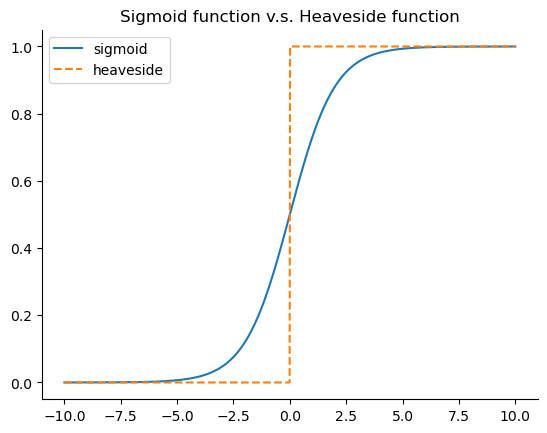

In [3]:
a = jnp.linspace(-10, 10, 1000)
y_sigmoid = sigmoid(a)
y_heaveside = heaveside(a)

plt.plot(a, y_sigmoid, c="tab:blue", label="sigmoid")
plt.plot(a, y_heaveside, "--", c="tab:orange", label="heaveside")
plt.legend()
sns.despine()
plt.title("Sigmoid function v.s. Heaveside function")


# plt.savefig("../graphs/sigmoid_v.s._heaveside.png")

plt.show()

# Softmax function

In [4]:
def softmax(x, t):
    a = jnp.max(x/t)
    return jnp.exp(x/t - a) / jnp.sum(jnp.exp(x/t - a))

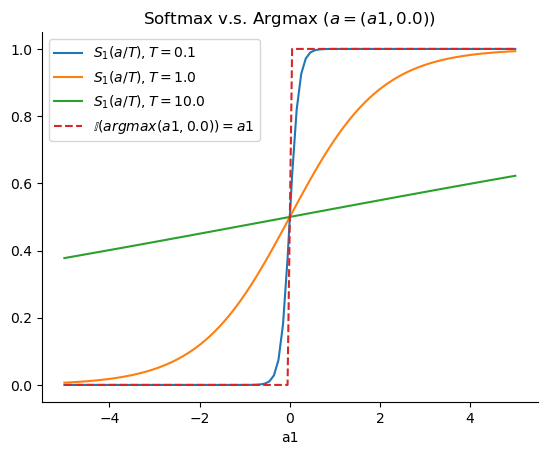

In [5]:
a1 = jnp.linspace(-5, 5, 100)

# fix a2=0
f = lambda x, t: jax.vmap(lambda x, t: softmax(jnp.array([x, .0]), t)[0])(x, t*jnp.ones(len(x)))


for t in [0.1, 1.0, 10.0]:
    plt.plot(a1, f(a1, t), label=f"$S_{1} (a/T), T={t}$")

plt.plot(a1, jnp.where(a1 > 0., 1, 0), "--", label=r"$\mathbb{I} (argmax(a1, 0.0)) = a1$")

plt.legend()
sns.despine()

plt.xlabel("a1")
plt.title("Softmax v.s. Argmax ($a=(a1, 0.0)$)")


# plt.savefig("../graphs/softmax.png")

plt.show()

In [6]:
from scipy.stats import norm, laplace, t

def plot_outlier_effect(
    save_path=None,
    outlier_pos=0,
    outliers=[8, 8.75, 9.5],
    bins=7,
    samples_norm_dist=30,
    samples_graph_xaxis=500,
    range_xaxis=[-5, 10],
    range_yaxis=[0, 0.60],
):
    """
    Sample from a normal distribution and plot the PDF for
    normal distribution, laplacian distribution, and the student T
    distribution. The function plots/saves data for distributions.
    If outliers are provided, we see the robustness of the student
    T distribution compared to the normal distribution.


    Args:
    ----------
    save_path : string
        The filenames to save the graphs

    outlier_pos : int, default=0
        Changes position of outliers

    outliers :  list, default=[]
        A list of outlier values

    bins : int, default=7
        Value of bin size for normal distribution histogram

    samples_norm_dist : int, default=30
        Number of samples to be taken from the normal distribution

    samples_graph_xaxis : int, default=500
        Number of values for the x-axis i.e the values the
        random variable can take

    range_xaxis : list, default=[-5, 10]
        The range of values for the x-axis

    range_yaxis : list, default=[0, 0.6]
        The range of values for the y-axis
    """

    # Set figure
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Generate Samples from normal distribution
    norm_dist_sample = random.normal(random.PRNGKey(42), shape=(samples_norm_dist,))

    
    # Plot the data from normal distribution without outliers
    for i in [0, 1]:
        ax[i].hist(
            jnp.array(norm_dist_sample),
            bins,
            color="steelblue",
            ec="steelblue",
            weights=[1 / norm_dist_sample.shape[0]] * norm_dist_sample.shape[0],
            rwidth=0.8,
        )

    # Generate values for x axis i.e. the values your random variable can take
    x_axis = jnp.linspace(range_xaxis[0], range_xaxis[1], samples_graph_xaxis) 

    # Plot outlier data
    ax[1].hist(
        jnp.array(outliers) + outlier_pos,
        len(outliers),
        color="steelblue",
        ec="steelblue",
        weights=[1 / (norm_dist_sample.shape[0] + len(outliers))] * len(outliers),
        rwidth=0.8,
    )
   
    # with outliers
    samples = jnp.hstack((norm_dist_sample, jnp.array(outliers) + outlier_pos))
    
    # Find range of values for PDF i.e y-axis
    y_range = range_yaxis

    for i, samples in enumerate([norm_dist_sample, samples]):
        # Calculate mean and standard deviation for different distributions and then
        # find the PDF for each distribution
        loc, scale = norm.fit(samples)
        norm_pdf = norm.pdf(x_axis, loc=loc, scale=scale)

        loc, scale = laplace.fit(samples)
        laplace_pdf = laplace.pdf(x_axis, loc=loc, scale=scale)

        fd, loc, scale = t.fit(samples)
        studentT_pdf = t.pdf(x_axis, fd, loc=loc, scale=scale)


        # Update tick intervals for x-axis
        ax[i].set_xticks(jnp.arange(range_xaxis[0], range_xaxis[1] + 1, 5))

        # Update the tick intervals and limit for y-axis
        ax[i].set_ylim(y_range)
        ax[i].set_yticks(jnp.linspace(y_range[0], y_range[1], 5))

        # Plot the different PDF's obtained
        ax[i].plot(x_axis, norm_pdf, "k--", linewidth=2.0)
        ax[i].plot(x_axis, studentT_pdf, "r-.", linewidth=2.0)
        ax[i].plot(x_axis, laplace_pdf, "b:", linewidth=2.0)

        # Update the Legend and the axis labels
        ax[i].legend(("gaussian", "student T", "laplace", "data"))
        ax[i].set_xlabel("$x$")
        ax[i].set_ylabel("$p(x)$")

        sns.despine()

    ax[0].set_title("Without outliers")
    ax[1].set_title("With outliers")

    if save_path:
        plt.savefig(save_path)

    plt.show()

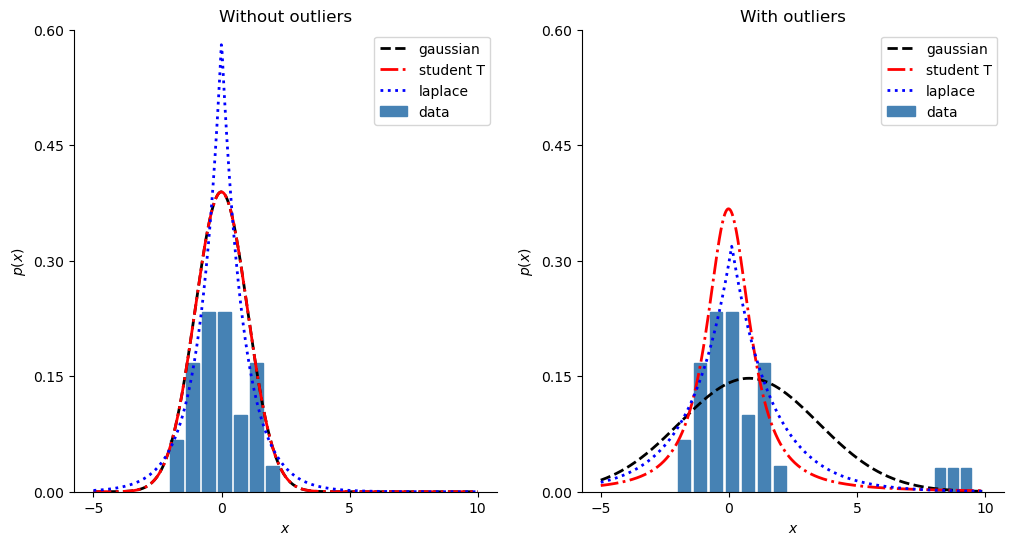

In [7]:
plot_outlier_effect(save_path="../graphs/fitting.png")